
# Assignment 2: Text Classification
Marko Praček, Vid Koncilja <div>
januar 2025

### Imports:

In [207]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve,cross_val_score,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import clone
import seaborn as sns
import optuna





In [247]:
label_mapping = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}


In [314]:
def plot_learning_curve(classifier, X_train, y_train, X_val, y_val, X_test, y_test):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train, y_train)

    val_accuracy = accuracy_score(y_val, pipeline.predict(X_val))
    test_accuracy = accuracy_score(y_test, pipeline.predict(X_test))
    print(f"Validation Accuracy: {val_accuracy:.2f}")
    print(f"Test Accuracy: {test_accuracy:.2f}")

  
    train_sizes = np.linspace(0.1, 1.0, 10)
    test_accuracies = []
    val_accuracies = []


    for train_size in train_sizes:
        current_train_data = X_train.sample(frac=train_size, random_state=42)
        y_current_train = y_train.loc[current_train_data.index]
        
        pipeline.fit(current_train_data, y_current_train)

        test_acc = accuracy_score(y_test, pipeline.predict(X_test))
        test_accuracies.append(test_acc)

        val_acc = accuracy_score(y_val, pipeline.predict(X_val))
        val_accuracies.append(val_acc)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, test_accuracies, label="Test Accuracy", color="blue")
    plt.plot(train_sizes, val_accuracies, label="Validation Accuracy", color="green")
    plt.xlabel("Training Set Size")
    plt.ylabel("Accuracy")
    plt.title(f"Learning Curve for {classifier.__class__.__name__} for different training sizes")
    plt.legend()
    plt.grid()
    plt.show()

    results = {
        'pipeline': pipeline,
        'train_sizes': train_sizes,
        'test_accuracies': test_accuracies,
        'val_accuracies': val_accuracies
    }
    
    return pipeline, results


In [261]:
def plot_confusion_matrix(pipeline, X_val, y_val, label_mapping, model_name="Classifier", ax=None):
    if ax is None:
        ax = plt.gca()
    y_val_pred = pipeline.predict(X_val)
    cm = confusion_matrix(y_val, y_val_pred)
    class_names = [f"{key} - {value}" for key, value in label_mapping.items()]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation='vertical', ax=ax)
    ax.set_title("Confusion Matrix for " + model_name)

def plot_feature_importance(pipeline, ax=None):
    if ax is None:
        ax = plt.gca()
    vectorizer = pipeline.named_steps['tfidf']
    classifier = pipeline.named_steps['classifier']
    feature_names = vectorizer.get_feature_names_out()
    feature_importance = classifier.feature_importances_
    important_words = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })
    important_words = important_words.sort_values(by='Importance', ascending=False)
    sns.barplot(data=important_words.head(10), x='Importance', y='Feature', color='blue', ax=ax)
    ax.set_title("Top 10 Most Important Features")
    ax.set_xlabel("Feature Importance")
    ax.set_ylabel("Feature")

def plot_cumulative_feature_importance(pipeline, ax=None):
    if ax is None:
        ax = plt.gca()
    vectorizer = pipeline.named_steps['tfidf']
    classifier = pipeline.named_steps['classifier']
    feature_names = vectorizer.get_feature_names_out()
    feature_importance = classifier.feature_importances_
    important_words = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })
    important_words = important_words.sort_values(by='Importance', ascending=False)
    cumulative_importance = important_words['Importance'].cumsum()
    ax.plot(range(len(cumulative_importance)), cumulative_importance, marker='o', color='purple')
    ax.set_title("Cumulative Feature Importance")
    ax.set_xlabel("Number of Features")
    ax.set_ylabel("Cumulative Importance")
    ax.grid()

def plot_tree_depth_distribution(pipeline, model_name="Classifier", ax=None):
    if ax is None:
        ax = plt.gca()
    rf_model = pipeline.named_steps['classifier']
    tree_depths = [estimator.tree_.max_depth for estimator in rf_model.estimators_]
    sns.histplot(tree_depths, bins=10, kde=True, color='green', ax=ax)
    ax.set_title("Distribution of Tree Depths")
    ax.set_xlabel("Tree Depth")
    ax.set_ylabel("Frequency")

def plot_all(pipeline, X_val, y_val, label_mapping, model_name="Classifier"):
    if model_name == "DecisionTreeClassifier":
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        plot_confusion_matrix(pipeline, X_val, y_val, label_mapping, model_name, ax=axes[0])
        plot_feature_importance(pipeline, ax=axes[1])
    else:
        fig, axes = plt.subplots(2, 2, figsize=(15, 6))
        plot_confusion_matrix(pipeline, X_val, y_val, label_mapping, model_name, ax=axes[0, 0])
        plot_feature_importance(pipeline, ax=axes[0, 1])
        plot_tree_depth_distribution(pipeline, model_name, ax=axes[1, 0])
        plot_cumulative_feature_importance(pipeline, ax=axes[1, 1])
    
    plt.tight_layout()  
    plt.show()

In [328]:
def plot_learning_curve_for_param(pipeline,param_name, param_values, X_train, y_train, X_val, y_val,y_test,X_test):
    test_accuracies = []
    val_accuracies = []
    
    for param_value in param_values:
        pipeline_copy = clone(pipeline)
        
        pipeline_copy.set_params(**{f'classifier__{param_name}': param_value})
        
        pipeline_copy.fit(X_train, y_train)
        
        test_acc = accuracy_score(y_test, pipeline_copy.predict(X_test))
        val_acc = accuracy_score(y_val, pipeline_copy.predict(X_val))

        test_accuracies.append(test_acc)
        val_accuracies.append(val_acc)

    plt.plot(param_values, test_accuracies, label="Test Accuracy", color="blue")
    plt.plot(param_values, val_accuracies, label="Validation Accuracy", color="green")
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    plt.title(f"Effect of {param_name} on Accuracy", fontsize=10)  
    plt.legend()
    plt.grid(True)

In [342]:
def plt_parameters(classifier_name, pipeline, param_name, param_values, X_train, y_train, X_val, y_val, y_test, X_test):
   
    num_params = len(param_name)
    num_rows = (num_params // 3) + (num_params % 3 > 0)  
    plt.figure(figsize=(12, 6 * num_rows)) 
    idx = 1
    
    for param_value in param_values:
        plt.subplot(num_rows, 3, idx)
        plot_learning_curve_for_param(pipeline, param_name[idx - 1], param_value, X_train, y_train, X_val, y_val, y_test, X_test)
        idx += 1
    
    plt.subplots_adjust(hspace=0.4, wspace=0.4, top=0.93)  
    fig = plt.gcf()
    fig.suptitle(f'{classifier_name} - Influence of different hyperparameters', fontsize=25)
    
    plt.tight_layout()
    plt.show()



# Task 1 - Data preparation and exploration


### Load the data and extract some basic information
- Are there missing values?
- what is the distribution of the class variable?
- How long are the texts?



MISSING VALUES
 text     0
label    0
dtype: int64

CLASS DISTRIBUTION
 label
1    1703
0    1443
3     671
4     584
2     401
5     198
Name: count, dtype: int64


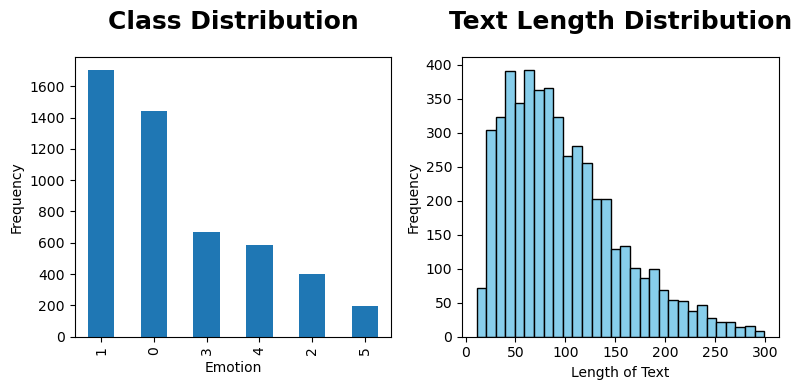

In [310]:
data = []
with open('dataset.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

df = pd.DataFrame(data)

#check if any data is missing
missing_values = df.isnull().sum()
print("\nMISSING VALUES\n",missing_values)



class_distribution = df['label'].value_counts()

print("\nCLASS DISTRIBUTION\n",class_distribution)

df['text_length'] = df['text'].apply(len)
text_length_stats = df['text_length'].describe()
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
class_distribution.plot(kind='bar', title='Class Distribution', xlabel='Emotion', ylabel='Frequency')
plt.subplot(1, 2, 2)
plt.hist(df['text_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Text Length Distribution')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Split the data into train, test, validation sets
#### We split data into train 60%, validation 20% and test 20%

In [378]:
df['text'] = df['text'].fillna("") 
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_data, val_data = train_test_split(train_data, test_size=0.25, stratify=train_data['label'], random_state=42)



X_train = train_data['text']
y_train = train_data['label']

X_val = val_data['text']
y_val = val_data['label']

X_test = test_data['text']
y_test = test_data['label']


# Task 2 - Basic machine learning

## Decision Tree Classifier
### First, we examine how well the Decision Tree Classifier learns with its default hyperparameters. We are also interested in how the size of the training data affects the results.

Validation Accuracy: 0.79
Test Accuracy: 0.81


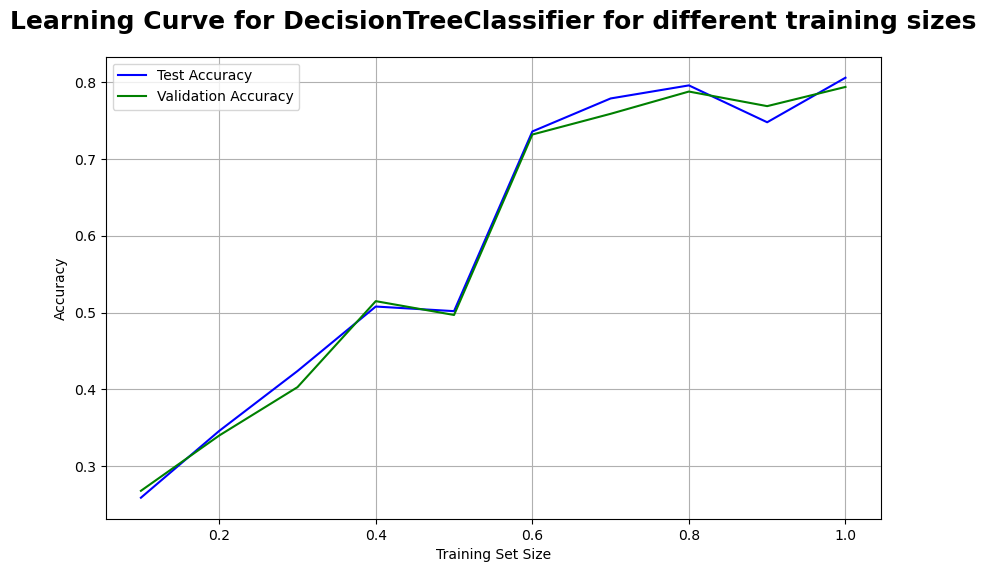

In [379]:

classifier = DecisionTreeClassifier(random_state=42)
pipeline, results = plot_learning_curve(classifier, X_train, y_train, X_val, y_val, X_test, y_test)


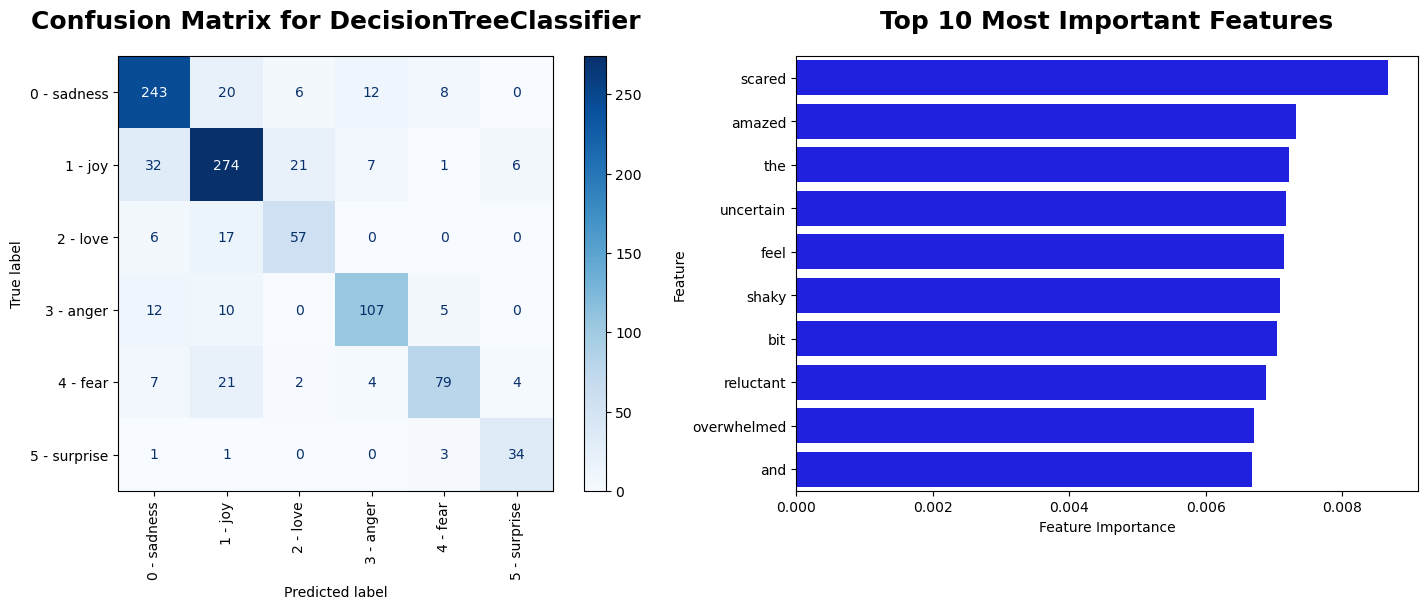

In [309]:
plot_all(pipeline,X_val,y_val,label_mapping,model_name="DecisionTreeClassifier")

### The results are quite good so we wanted to see how the hyperparameters affect the models result

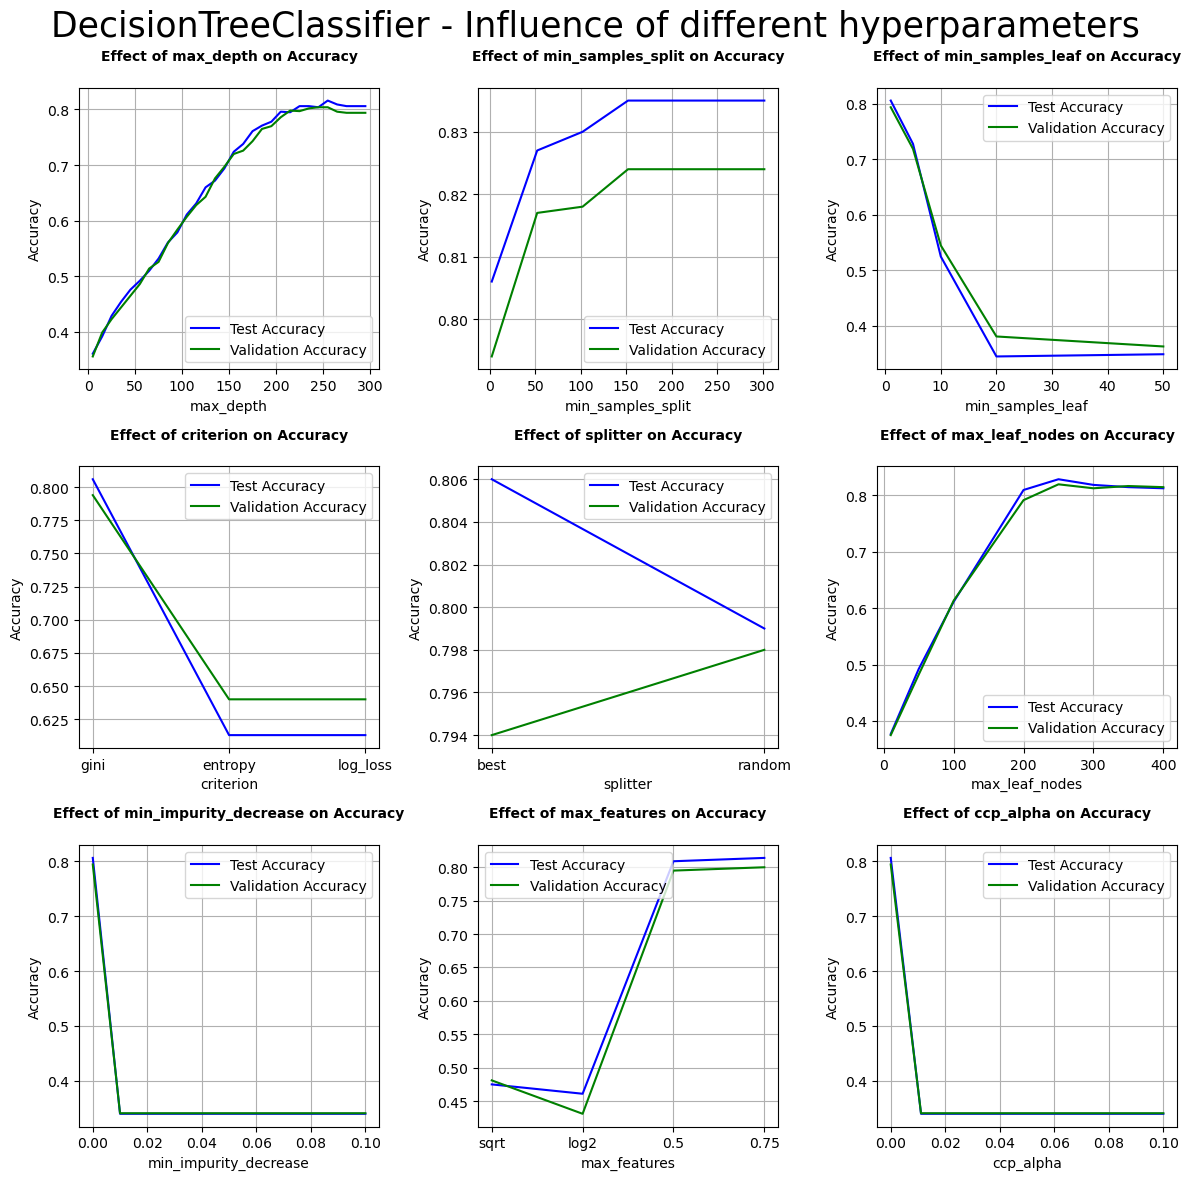

In [330]:

para_names = ["max_depth", "min_samples_split", "min_samples_leaf", "criterion", "splitter", "max_leaf_nodes", "min_impurity_decrease", "max_features", "ccp_alpha"]
para_values = [np.arange(5, 300, 10), np.arange(2, 350, 50), [1, 5, 10, 20, 50], ['gini', 'entropy', 'log_loss'], ['best', 'random'], [10, 50, 100, 200, 250, 300, 350, 400], [0.0, 0.01, 0.05, 0.1], ['sqrt', 'log2', 0.5, 0.75], np.linspace(0.0, 0.1, 10)]
plt_parameters("DecisionTreeClassifier", pipeline,para_names, para_values, X_train, y_train, X_val, y_val,y_test,X_test)

In [86]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define StratifiedKFold for consistent class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the pipeline using cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')

# Print Cross-Validation Results
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.2f}")
print(f"Standard Deviation of CV Accuracy: {np.std(cv_scores):.2f}")


Cross-Validation Accuracy Scores: [0.64666667 0.78       0.54333333 0.59       0.51      ]
Mean CV Accuracy: 0.61
Standard Deviation of CV Accuracy: 0.09


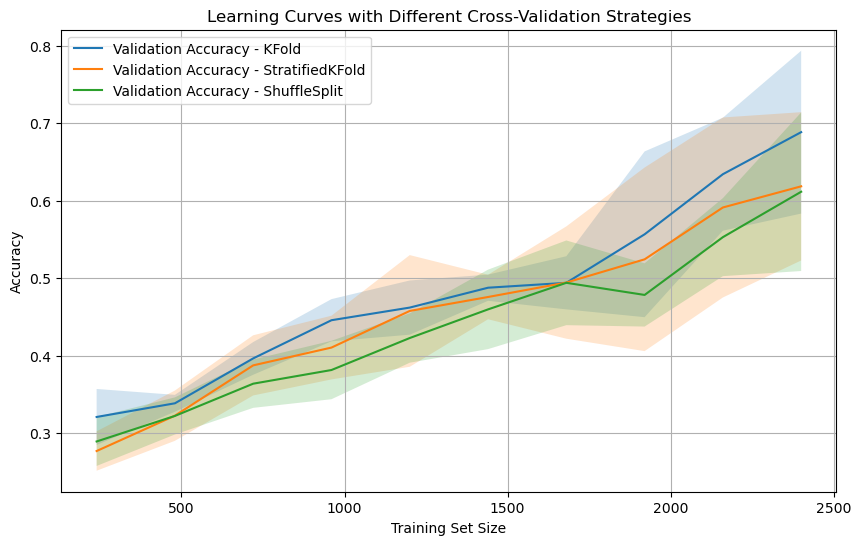

In [93]:
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np

# Define best parameters for the DecisionTreeClassifier
best_params = {
    'classifier__criterion': 'gini',
    'classifier__max_depth': None,
    'classifier__max_features': None,
    'classifier__min_samples_leaf': 1,
    'classifier__min_samples_split': 20
}

# Define cross-validation strategies
cv_strategies = {
    'KFold': KFold(n_splits=5, shuffle=True, random_state=42),
    'StratifiedKFold': StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    'ShuffleSplit': ShuffleSplit(n_splits=5, test_size=0.2, random_state=42),
}

# Store results for plotting
results = {}

# Create pipeline with best parameters for DecisionTreeClassifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', DecisionTreeClassifier(
        criterion=best_params['classifier__criterion'],
        max_depth=best_params['classifier__max_depth'],
        max_features=best_params['classifier__max_features'],
        min_samples_leaf=best_params['classifier__min_samples_leaf'],
        min_samples_split=best_params['classifier__min_samples_split'],
        random_state=42
    ))
])

# Loop through each cross-validation strategy
for cv_name, cv in cv_strategies.items():
    # Calculate learning curve with cross-validation
    train_sizes, train_scores, val_scores = learning_curve(
        pipeline, 
        X_train, 
        y_train, 
        cv=cv, 
        scoring='accuracy', 
        train_sizes=np.linspace(0.1, 1.0, 10), 
        random_state=42,
        n_jobs=-1
    )

    # Calculate mean and standard deviation of scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Store the results for this CV strategy
    results[cv_name] = (train_sizes, train_mean, train_std, val_mean, val_std)

# Plot Learning Curves for each cross-validation strategy
plt.figure(figsize=(10, 6))

# Loop through the results and plot for each strategy
for cv_name, (train_sizes, train_mean, train_std, val_mean, val_std) in results.items():
    plt.plot(train_sizes, val_mean, label=f'Validation Accuracy - {cv_name}')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves with Different Cross-Validation Strategies')
plt.legend()
plt.grid()
plt.show()


### We got the best hyperparameters for Decision Tree Classifier

In [147]:

def objective(trial):
  
    max_depth = trial.suggest_categorical('classifier__max_depth', [5, 10, 15, None])
    min_samples_split = trial.suggest_int('classifier__min_samples_split', 2, 20, step=2)
    min_samples_leaf = trial.suggest_int('classifier__min_samples_leaf', 1, 9, step=2)
    criterion = trial.suggest_categorical('classifier__criterion', ['gini', 'entropy'])
    max_features = trial.suggest_categorical('classifier__max_features', ['sqrt', 'log2', None])
    
    pipeline.set_params(
        classifier__max_depth=max_depth,
        classifier__min_samples_split=min_samples_split,
        classifier__min_samples_leaf=min_samples_leaf,
        classifier__criterion=criterion,
        classifier__max_features=max_features
    )
    score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='accuracy')
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_trial = study.best_trial
print(f"Best Parameters: {best_trial.params}")
print(f"Best Score: {best_trial.value}")

best_model = pipeline.set_params(**best_trial.params)
best_model.fit(X_train, y_train)

test_accuracy = accuracy_score(y_test, best_model.predict(X_test))
print(f"\nTEST ACCURACY WITH THE BEST MODEL:\n{test_accuracy:.2f}")


[I 2025-01-08 18:02:59,054] A new study created in memory with name: no-name-cd056a26-dc52-4041-8296-74bc49d65619
[I 2025-01-08 18:03:02,703] Trial 0 finished with value: 0.344 and parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 7, 'classifier__criterion': 'entropy', 'classifier__max_features': 'log2'}. Best is trial 0 with value: 0.344.
[I 2025-01-08 18:03:04,939] Trial 1 finished with value: 0.7256666666666666 and parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 16, 'classifier__min_samples_leaf': 1, 'classifier__criterion': 'gini', 'classifier__max_features': 'sqrt'}. Best is trial 1 with value: 0.7256666666666666.
[I 2025-01-08 18:03:05,074] Trial 2 finished with value: 0.376 and parameters: {'classifier__max_depth': 15, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 3, 'classifier__criterion': 'entropy', 'classifier__max_features': 'sqrt'}. Best is trial 1 with value: 0

Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 18, 'classifier__min_samples_leaf': 1, 'classifier__criterion': 'gini', 'classifier__max_features': None}
Best Score: 0.8453333333333335

TEST ACCURACY WITH THE BEST MODEL:
0.85


## RANDOM FOREST CLASSIFIER
### Results for differen parameters


In [331]:


pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', RandomForestClassifier(random_state=42))
])




Validation Accuracy: 0.68
Test Accuracy: 0.67


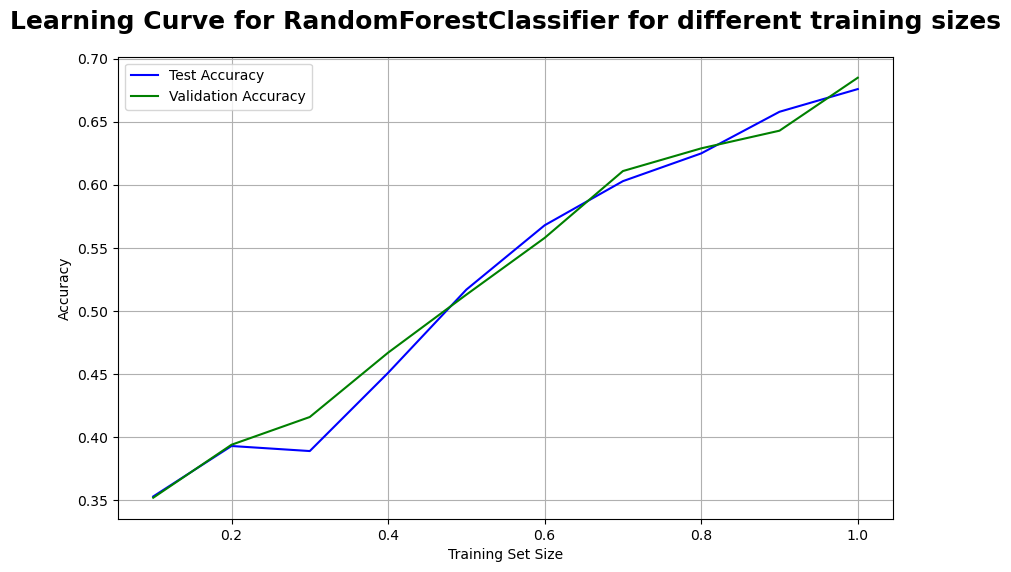

In [332]:
classifier = RandomForestClassifier(random_state=42)
pipeline, results = plot_learning_curve(classifier, X_train, y_train, X_val, y_val, X_test, y_test)


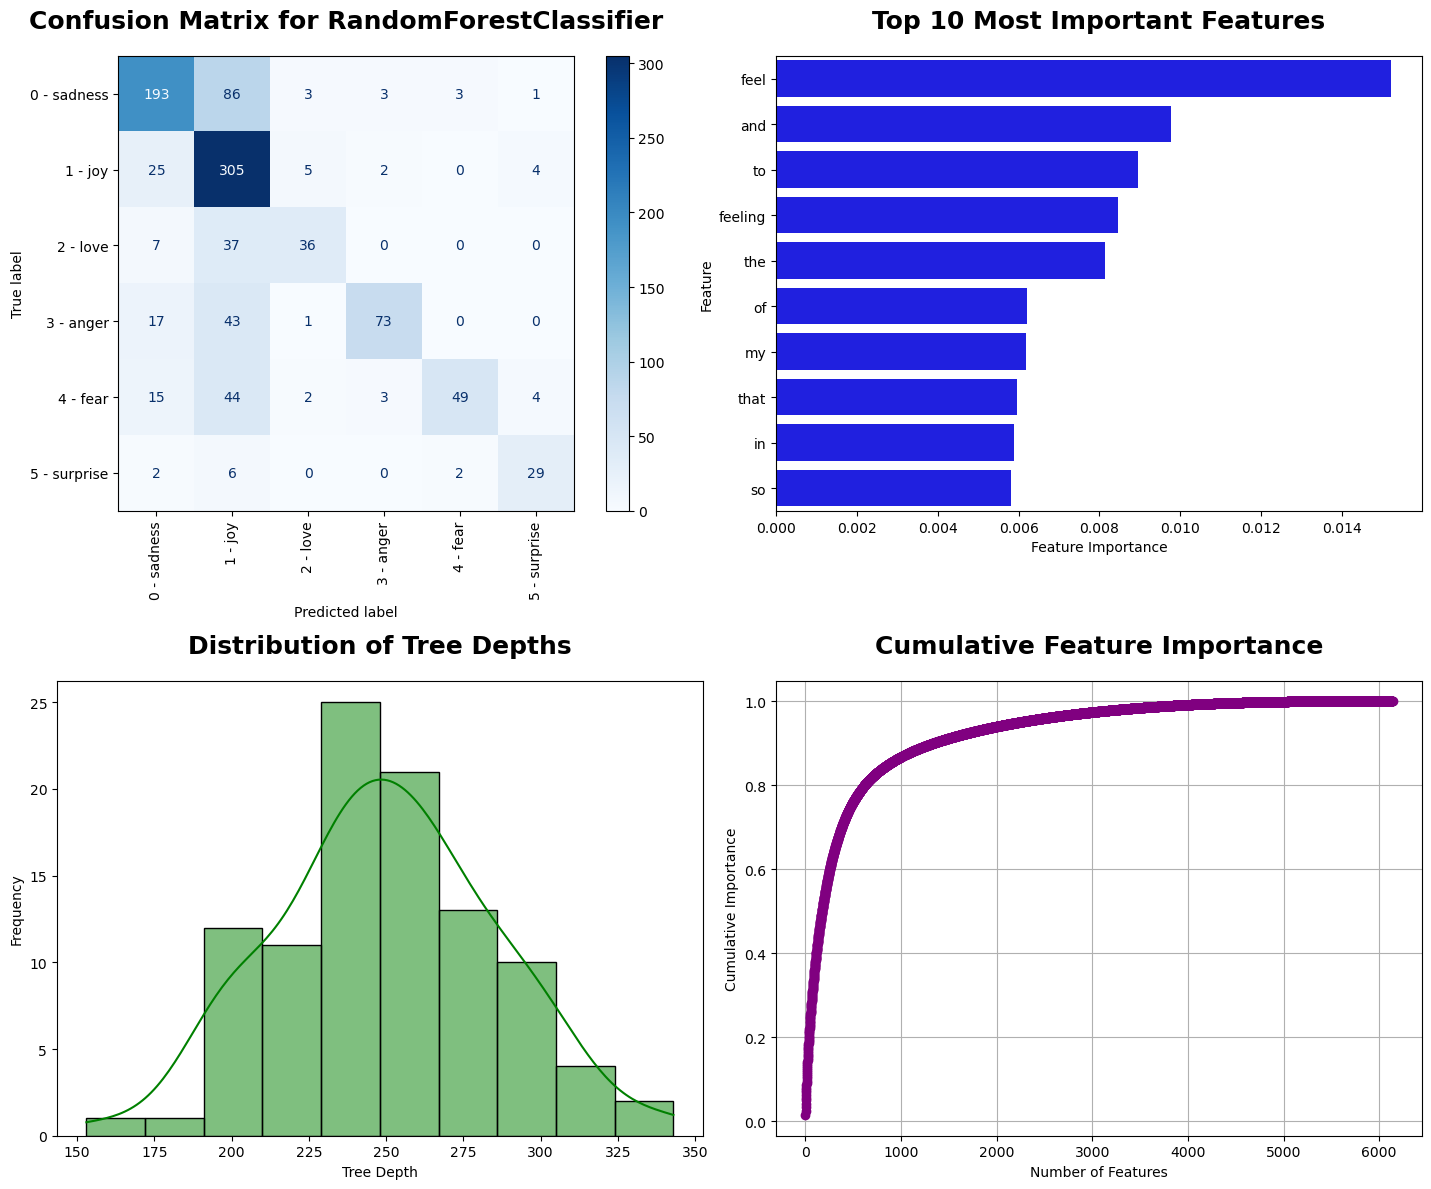

In [333]:
plot_all(pipeline,X_val,y_val,label_mapping,model_name="RandomForestClassifier")

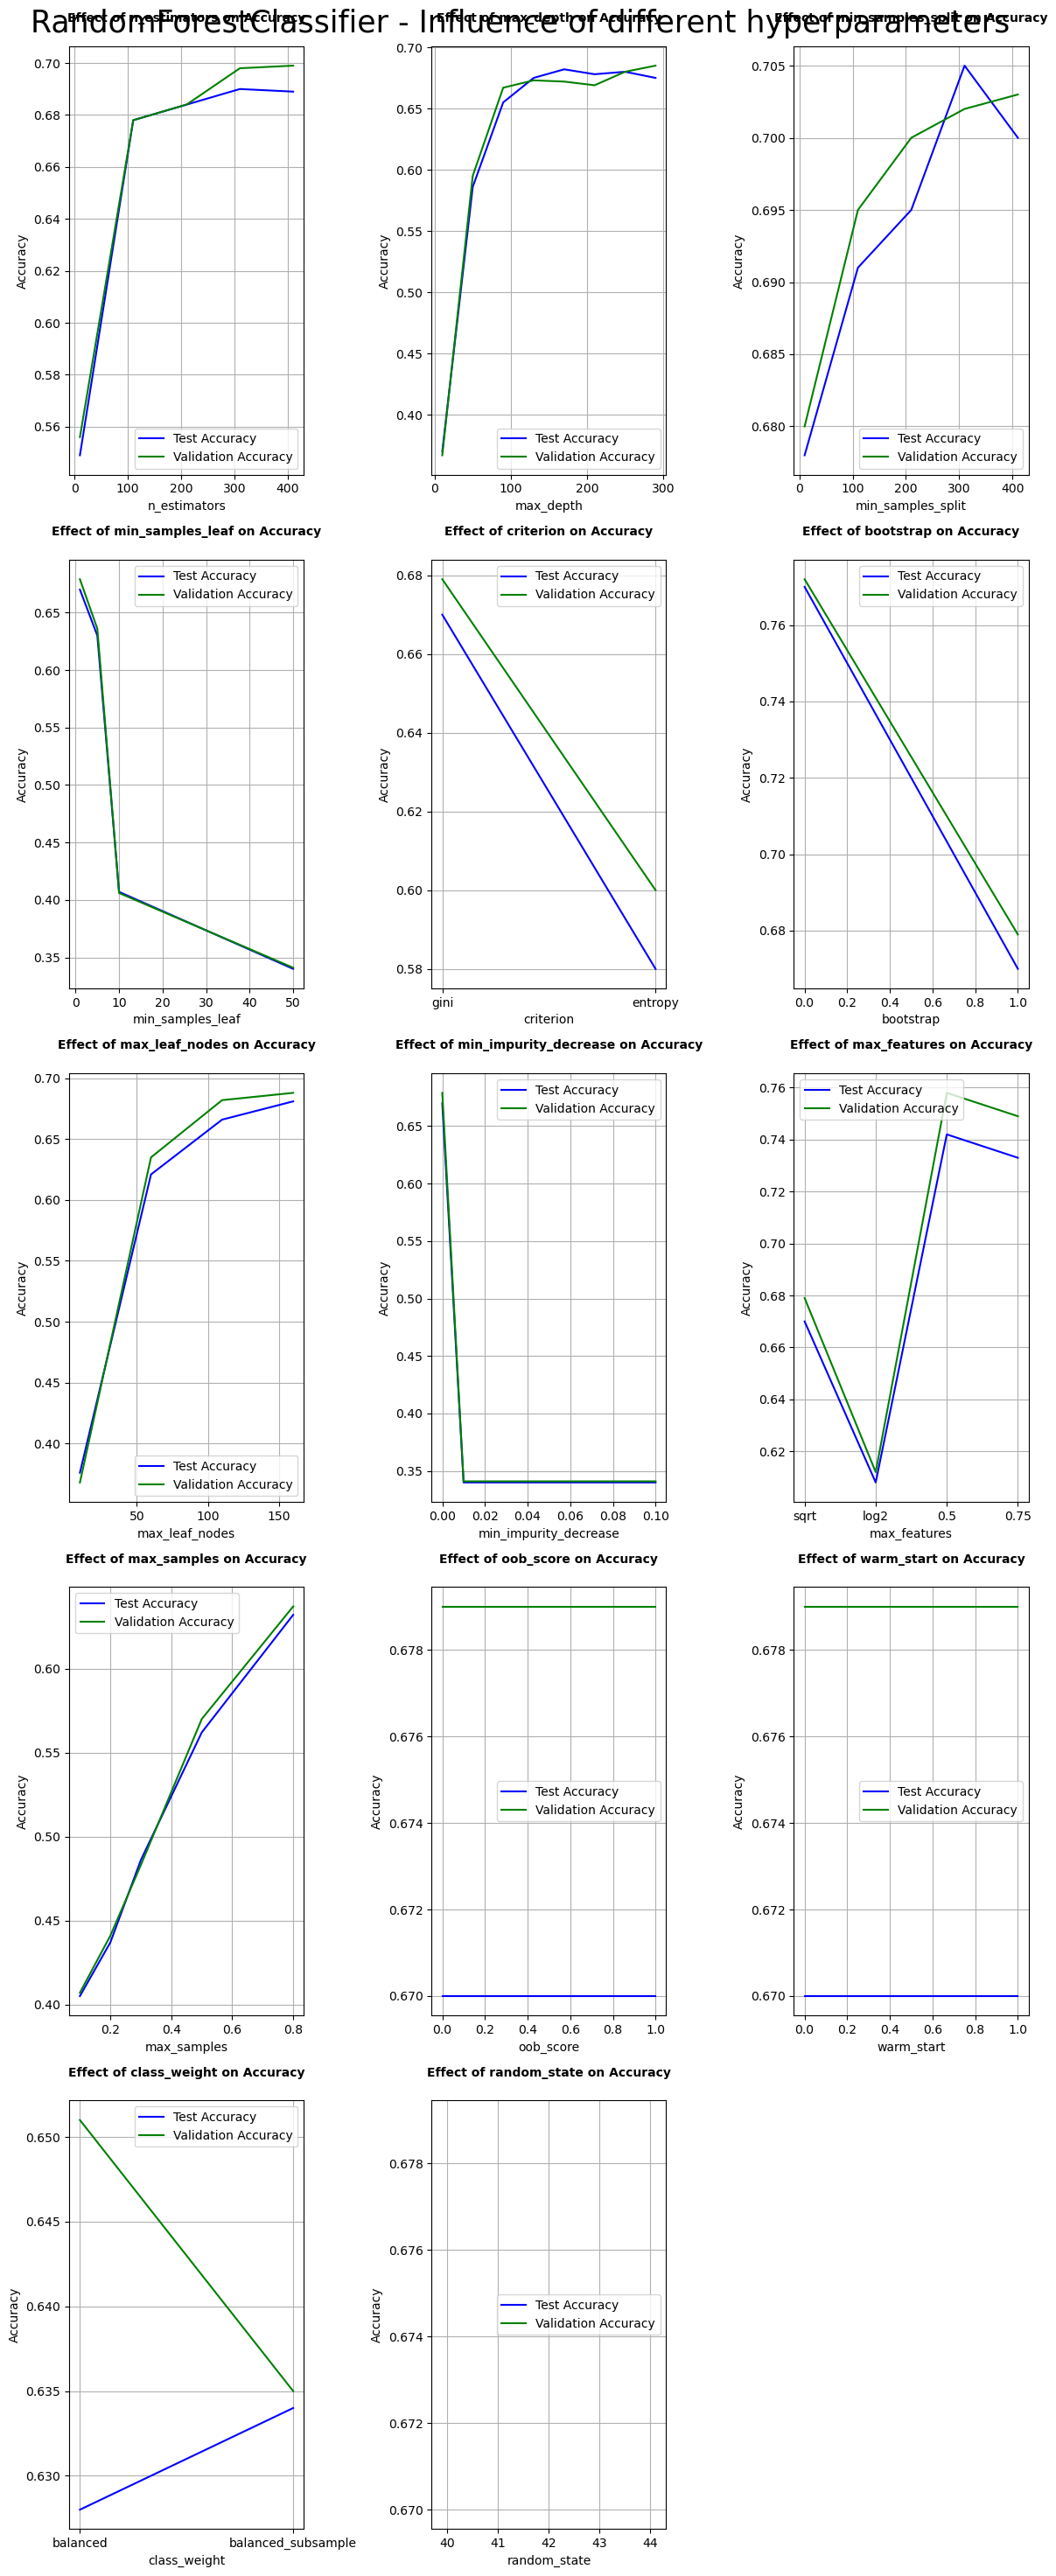

In [343]:
para_names_RF = ["n_estimators", "max_depth", "min_samples_split", "min_samples_leaf", "criterion", "bootstrap", "max_leaf_nodes", "min_impurity_decrease", "max_features", "max_samples", "oob_score", "warm_start", "class_weight", "random_state"]
para_values_RF = [np.arange(10,500,100), np.arange(10, 300, 40), np.arange(10,500,100), [1, 5, 10, 50], ['gini', 'entropy'], [True, False], np.arange(10,200,50), [0.0, 0.01, 0.05, 0.1], ['sqrt', 'log2', 0.5, 0.75], [0.1, 0.2, 0.3, 0.5, 0.8], [True, False], [True, False], ['balanced', 'balanced_subsample'], [42]]
plt_parameters("RandomForestClassifier", pipeline,para_names_RF, para_values_RF, X_train, y_train, X_val, y_val,y_test,X_test)


In [151]:
def objective(trial):

    model = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 100, 200),
            max_depth=trial.suggest_int('max_depth', 10, 100),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 50),
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20),
            criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
            bootstrap=trial.suggest_categorical('bootstrap', [True, False]),
            max_leaf_nodes=trial.suggest_int('max_leaf_nodes', 10, 100),
        ))
    ])

    model.fit(X_train, y_train)
    
    
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f"Best hyperparameters: {study.best_params}")

best_model_optuna = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', RandomForestClassifier(
        n_estimators=study.best_params['n_estimators'],
        max_depth=study.best_params['max_depth'],
        min_samples_split=study.best_params['min_samples_split'],
        min_samples_leaf=study.best_params['min_samples_leaf'],
        criterion=study.best_params['criterion'],
        bootstrap=study.best_params['bootstrap'],
        max_leaf_nodes=study.best_params['max_leaf_nodes'],
    ))
])

best_model_optuna.fit(X_train, y_train)

train_accuracy_optuna = accuracy_score(y_train, best_model_optuna.predict(X_train))
print(f"TRAIN ACCURACY WITH THE BEST MODEL: {train_accuracy_optuna:.2f}")
test_accuracy_optuna = accuracy_score(y_test, best_model_optuna.predict(X_test))
print(f"TEST ACCURACY WITH THE BEST MODEL: {test_accuracy_optuna:.2f}")


[I 2025-01-08 19:02:08,145] A new study created in memory with name: no-name-d13b59f7-c1ce-47ea-b426-69e694d4cd30
[I 2025-01-08 19:02:09,005] Trial 0 finished with value: 0.399 and parameters: {'n_estimators': 145, 'max_depth': 79, 'min_samples_split': 12, 'min_samples_leaf': 10, 'criterion': 'gini', 'bootstrap': True, 'max_leaf_nodes': 19}. Best is trial 0 with value: 0.399.
[I 2025-01-08 19:02:10,340] Trial 1 finished with value: 0.481 and parameters: {'n_estimators': 170, 'max_depth': 44, 'min_samples_split': 13, 'min_samples_leaf': 11, 'criterion': 'entropy', 'bootstrap': False, 'max_leaf_nodes': 32}. Best is trial 1 with value: 0.481.
[I 2025-01-08 19:02:11,096] Trial 2 finished with value: 0.402 and parameters: {'n_estimators': 150, 'max_depth': 87, 'min_samples_split': 36, 'min_samples_leaf': 16, 'criterion': 'gini', 'bootstrap': False, 'max_leaf_nodes': 76}. Best is trial 1 with value: 0.481.
[I 2025-01-08 19:02:11,602] Trial 3 finished with value: 0.406 and parameters: {'n_est

Best hyperparameters: {'n_estimators': 191, 'max_depth': 100, 'min_samples_split': 35, 'min_samples_leaf': 1, 'criterion': 'entropy', 'bootstrap': False, 'max_leaf_nodes': 97}
TRAIN ACCURACY WITH THE BEST MODEL: 0.84
TEST ACCURACY WITH THE BEST MODEL: 0.72


## SVC - Support Vector Classification

Validation Accuracy: 0.61
Test Accuracy: 0.63


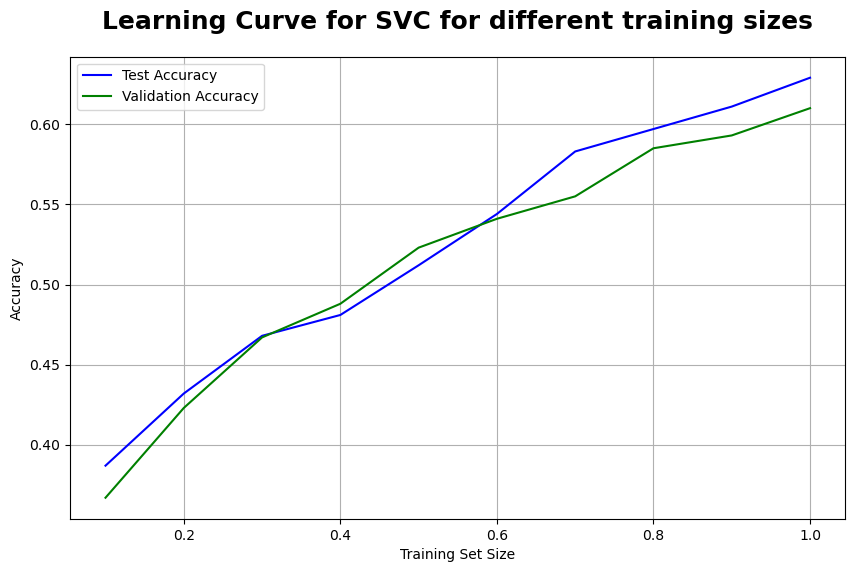

In [344]:

classifier = SVC(random_state=42)
pipeline, results = plot_learning_curve(classifier, X_train, y_train, X_val, y_val, X_test, y_test)

c:\Users\Vid\miniconda3\envs\ls_a01\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


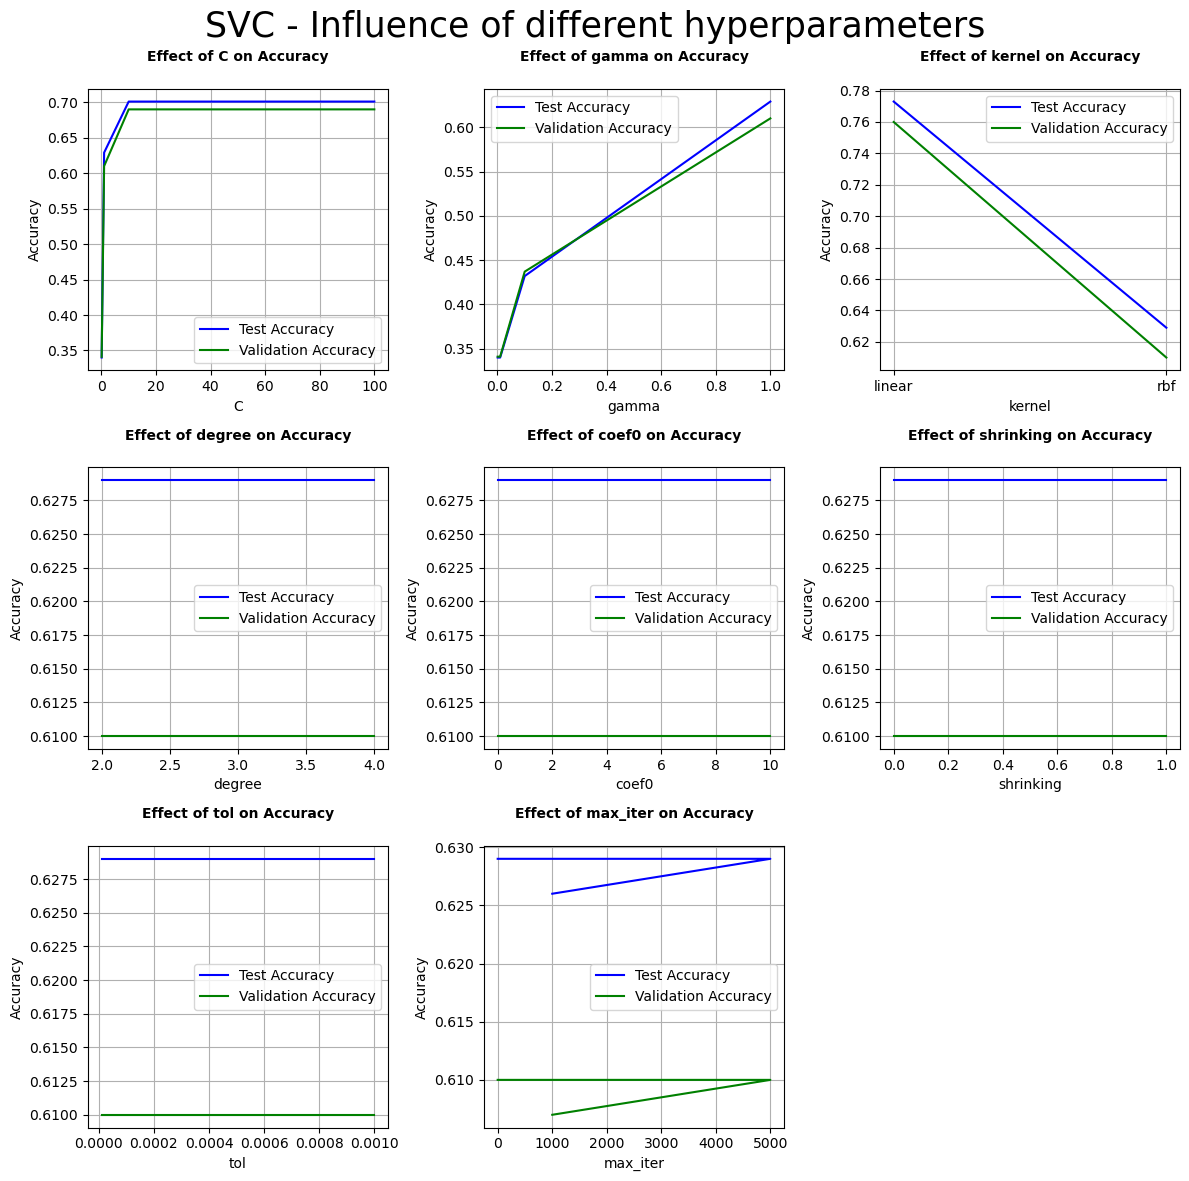

In [153]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', SVC())
])

C_values = [0.1, 1, 10, 100]
plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plot_learning_curve_for_param('C', C_values, X_train, y_train, X_val, y_val)

gamma_values = [0.001, 0.01, 0.1, 1]
plt.subplot(3, 3, 2)
plot_learning_curve_for_param('gamma', gamma_values, X_train, y_train, X_val, y_val)

kernel_values = ['linear', 'rbf']
plt.subplot(3, 3, 3)
plot_learning_curve_for_param('kernel', kernel_values, X_train, y_train, X_val, y_val)

degree_values = [2, 3, 4]
plt.subplot(3, 3, 4)
plot_learning_curve_for_param('degree', degree_values, X_train, y_train, X_val, y_val)

coef0_values = [0, 0.1, 1, 10]
plt.subplot(3, 3, 5)
plot_learning_curve_for_param('coef0', coef0_values, X_train, y_train, X_val, y_val)

shrinking_values = [True, False]
plt.subplot(3, 3, 6)
plot_learning_curve_for_param('shrinking', shrinking_values, X_train, y_train, X_val, y_val)

tol_values = [1e-5, 1e-4, 1e-3]
plt.subplot(3, 3, 7)
plot_learning_curve_for_param('tol', tol_values, X_train, y_train, X_val, y_val)

max_iter_values = [1000, 5000, -1] 
plt.subplot(3, 3, 8)
plot_learning_curve_for_param('max_iter', max_iter_values, X_train, y_train, X_val, y_val)


fig = plt.gcf()
fig.suptitle('SVC - Influence of different hyperparameters', fontsize=25)

plt.tight_layout()
plt.show()


In [154]:


pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', SVC())
])

def objective(trial):
    C = trial.suggest_float('classifier__C', 0.1, 100, log=True)
    gamma = trial.suggest_float('classifier__gamma', 0.001, 1, log=True)
    kernel = trial.suggest_categorical('classifier__kernel', ['rbf', 'linear']) 
    
    pipeline.set_params(
        classifier__C=C,
        classifier__gamma=gamma,
        classifier__kernel=kernel
    )
    
    score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=5, scoring='accuracy')
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  

best_trial = study.best_trial
print(f"Best Parameters: {best_trial.params}")
print(f"Best Score: {best_trial.value}")

best_model = pipeline.set_params(**best_trial.params)
best_model.fit(X_train, y_train)

test_accuracy = accuracy_score(y_test, best_model.predict(X_test))
print(f"Test Accuracy with Best Model: {test_accuracy:.2f}")


[I 2025-01-08 19:15:33,739] A new study created in memory with name: no-name-8add7a55-9639-48a6-89e6-8a39a785fe61
[I 2025-01-08 19:15:43,541] Trial 0 finished with value: 0.6826666666666666 and parameters: {'classifier__C': 34.46851018601867, 'classifier__gamma': 0.8563665607417739, 'classifier__kernel': 'rbf'}. Best is trial 0 with value: 0.6826666666666666.
[I 2025-01-08 19:15:50,466] Trial 1 finished with value: 0.34266666666666673 and parameters: {'classifier__C': 0.11235906943202914, 'classifier__gamma': 0.8171185183587186, 'classifier__kernel': 'linear'}. Best is trial 0 with value: 0.6826666666666666.
[I 2025-01-08 19:15:54,239] Trial 2 finished with value: 0.6359999999999999 and parameters: {'classifier__C': 0.6213428452038015, 'classifier__gamma': 0.009045743631190368, 'classifier__kernel': 'linear'}. Best is trial 0 with value: 0.6826666666666666.
[I 2025-01-08 19:15:58,426] Trial 3 finished with value: 0.7376666666666667 and parameters: {'classifier__C': 73.48547193764956, '

Best Parameters: {'classifier__C': 39.107622587561266, 'classifier__gamma': 0.02908880927811331, 'classifier__kernel': 'rbf'}
Best Score: 0.7686666666666666
Test Accuracy with Best Model: 0.80


## TASK 3 Advanced Machine learning

In [176]:
from datasets import load_dataset
dataset = load_dataset("dair-ai/emotion")



c:\Users\Vid\miniconda3\envs\ls_a01\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Vid\.cache\huggingface\hub\datasets--dair-ai--emotion. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating test split: 100%|██████████| 2000/2000 [00:00<00:00, 285462.74 examples/s]


In [374]:
%python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ------ --------------------------------- 2.1/12.8 MB 10.7 MB/s eta 0:00:02
     ------------- -------------------------- 4.2/12.8 MB 10.5 MB/s eta 0:00:01
     ------------------ --------------------- 6.0/12.8 MB 9.5 MB/s eta 0:00:01
     -------------------------- ------------- 8.4/12.8 MB 9.8 MB/s eta 0:00:01
     -------------------------------- ------ 10.7/12.8 MB 10.2 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 10.2 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 9.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [377]:
# Import required libraries
from datasets import load_dataset
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm import tqdm

# Download NLTK resources
nltk.download('stopwords')
#stop_words = set(stopwords.words('english'))

# Load SpaCy model for lemmatization
nlp = spacy.load('en_core_web_sm')

# Define a function to expand contractions
contractions = {
    "don't": "do not",
    "can't": "cannot",
    "i'm": "i am",
    "it's": "it is",
    "he's": "he is",
    "she's": "she is",
    "you're": "you are",
    "we're": "we are",
    "they're": "they are",
    "i've": "i have",
    "we've": "we have",
    "they've": "they have",
    "you've": "you have",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "hasn't": "has not",
    "haven't": "have not",
    "won't": "will not",
    "wouldn't": "would not",
    "couldn't": "could not",
    "shouldn't": "should not",
    "didn't": "did not",
    "doesn't": "does not"
}

def expand_contractions(text):
    for contraction, expanded in contractions.items():
        text = re.sub(r'\b' + contraction + r'\b', expanded, text)
    return text

# Define a preprocessing function
def preprocess_text(text, use_stemming=False):
    # Lowercase the text
    text = text.lower()
    
    # Expand contractions
    text = expand_contractions(text)
    
    # Tokenize the text using SpaCy
    #doc = nlp(text)
    
    # Remove stopwords and perform lemmatization/stemming
    processed_text = []
    for token in doc:
        if token.text not in stop_words and token.is_alpha:  # Remove stopwords and non-alphabetic tokens
            if use_stemming:
                stemmer = PorterStemmer()
                processed_text.append(stemmer.stem(token.text))
            else:
                processed_text.append(token.lemma_)
    
    return " ".join(processed_text)

# Load the 'dair-ai/emotion' dataset
dataset = load_dataset("dair-ai/emotion")

# Access the train, validation, and test splits
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

# Prepare the texts and labels
train_texts = train_data['text']
train_labels = train_data['label']
val_texts = val_data['text']
val_labels = val_data['label']
test_texts = test_data['text']
test_labels = test_data['label']

# Apply preprocessing to train, validation, and test texts
# train_texts_cleaned = [preprocess_text(text) for text in tqdm(train_texts)]
# val_texts_cleaned = [preprocess_text(text) for text in tqdm(val_texts)]
# test_texts_cleaned = [preprocess_text(text) for text in tqdm(test_texts)]
train_texts_cleaned = train_texts
val_texts_cleaned = val_texts
test_texts_cleaned = test_texts
# Tokenize the text data
max_words = 10000  # Vocabulary size
max_len = 100  # Max length of input sequences

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts_cleaned)  # Use cleaned texts for consistency
train_sequences = tokenizer.texts_to_sequences(train_texts_cleaned)
val_sequences = tokenizer.texts_to_sequences(val_texts_cleaned)
test_sequences = tokenizer.texts_to_sequences(test_texts_cleaned)

# Pad sequences to make them of equal length
X_train = pad_sequences(train_sequences, maxlen=max_len)
X_val = pad_sequences(val_sequences, maxlen=max_len)
X_test = pad_sequences(test_sequences, maxlen=max_len)

# Convert labels to categorical
num_classes = len(set(train_labels))  # Determine the number of emotion classes
y_train = to_categorical(train_labels, num_classes=num_classes)
y_val = to_categorical(val_labels, num_classes=num_classes)
y_test = to_categorical(test_labels, num_classes=num_classes)

# Define the CNN model
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=max_words, output_dim=100, input_length=X_train.shape[1]))

# Convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

# Max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Global max pooling layer
model.add(GlobalMaxPooling1D())

# Fully connected layers
model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)))  # L2 regularization
model.add(Dropout(0.5))  # Dropout for regularization
model.add(Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Classification report for detailed metrics
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)
y_test_classes = y_test.argmax(axis=-1)
print(classification_report(y_test_classes, y_pred_classes))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\Vid\miniconda3\envs\ls_a01\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_17 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_8          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.3928 - loss: 1.7664 - val_accuracy: 0.8690 - val_loss: 0.4992
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8835 - loss: 0.4290 - val_accuracy: 0.9210 - val_loss: 0.2593
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9279 - loss: 0.2541 - val_accuracy: 0.9250 - val_loss: 0.2315
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9419 - loss: 0.2039 - val_accuracy: 0.9245 - val_loss: 0.2256
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9510 - loss: 0.1691 - val_accuracy: 0.9225 - val_loss: 0.2436
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9592 - loss: 0.1479 - val_accuracy: 0.9200 - val_loss: 0.2343
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9666 - loss: 0.1286 - val_accuracy: 0.9180 - val_loss: 0.2434
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9678 - loss: 0.1184 - val_acc

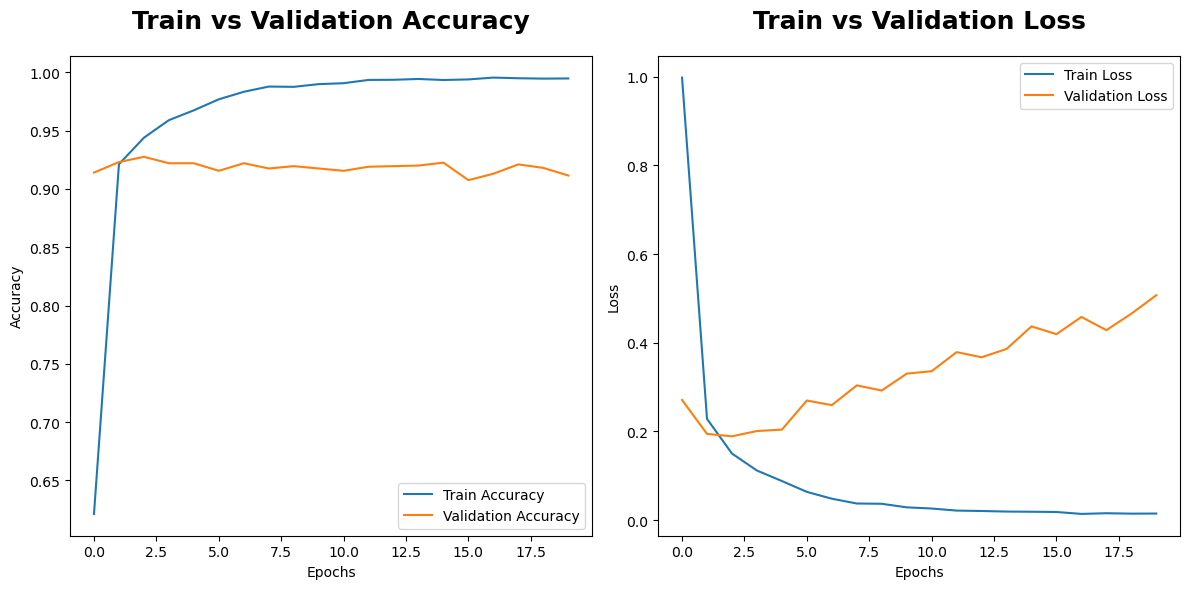

In [202]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [354]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the parameters
max_words = 10000  # You can adjust this as needed
max_len = 100  # Set the maximum length for sequences

# Tokenize the text data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)  # Fit on the training text
train_sequences = tokenizer.texts_to_sequences(train_texts)  # Convert train text to sequences
val_sequences = tokenizer.texts_to_sequences(val_texts)  # Convert validation text to sequences
test_sequences = tokenizer.texts_to_sequences(test_texts)  # Convert test text to sequences

# Pad sequences to ensure all have the same length
X_train = pad_sequences(train_sequences, maxlen=max_len)
X_val = pad_sequences(val_sequences, maxlen=max_len)
X_test = pad_sequences(test_sequences, maxlen=max_len)

# Now X_train, X_val, and X_test will be 2D arrays with shape (num_samples, max_len)
print(X_train.shape)  # This should print (3000, max_len)



(16000, 100)


In [355]:
# Ensure that the labels correspond to the same number of samples as the inputs
y_train = to_categorical(train_labels, num_classes=6)
y_val = to_categorical(val_labels, num_classes=6)
y_test = to_categorical(test_labels, num_classes=6)

# Check the shapes after conversion
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (16000, 100), y_train shape: (16000, 6)
X_val shape: (2000, 100), y_val shape: (2000, 6)
X_test shape: (2000, 100), y_test shape: (2000, 6)


In [357]:
from tensorflow.keras.layers import Bidirectional, LSTM

# Define the model with Bidirectional LSTM
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=max_words, output_dim=100, input_length=X_train.shape[1]))

# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(128)))

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Evaluate the model on the test set
val_loss, val_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {val_acc * 100:.2f}%")


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 145ms/step - accuracy: 0.3909 - loss: 1.5393 - val_accuracy: 0.7090 - val_loss: 0.7842
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 73s 146ms/step - accuracy: 0.7530 - loss: 0.6744 - val_accuracy: 0.8525 - val_loss: 0.4220
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - accuracy: 0.8988 - loss: 0.3014 - val_accuracy: 0.9080 - val_loss: 0.2849
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 165ms/step - accuracy: 0.9377 - loss: 0.1788 - val_accuracy: 0.9275 - val_loss: 0.2405
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 77s 155ms/step - accuracy: 0.9556 - loss: 0.1254 - val_accuracy: 0.9170 - val_loss: 0.2470
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 83s 165ms/step - accuracy: 0.9691 - loss: 0.0949 - val_accuracy: 0.9280 - val_loss: 0.2615
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 72s 144ms/step - accuracy: 0.9744 - loss: 0.0741 - val_accuracy: 0.9250 - val_loss: 0.2613
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 73s 145ms/step - accuracy: 0.9791 - loss: 0

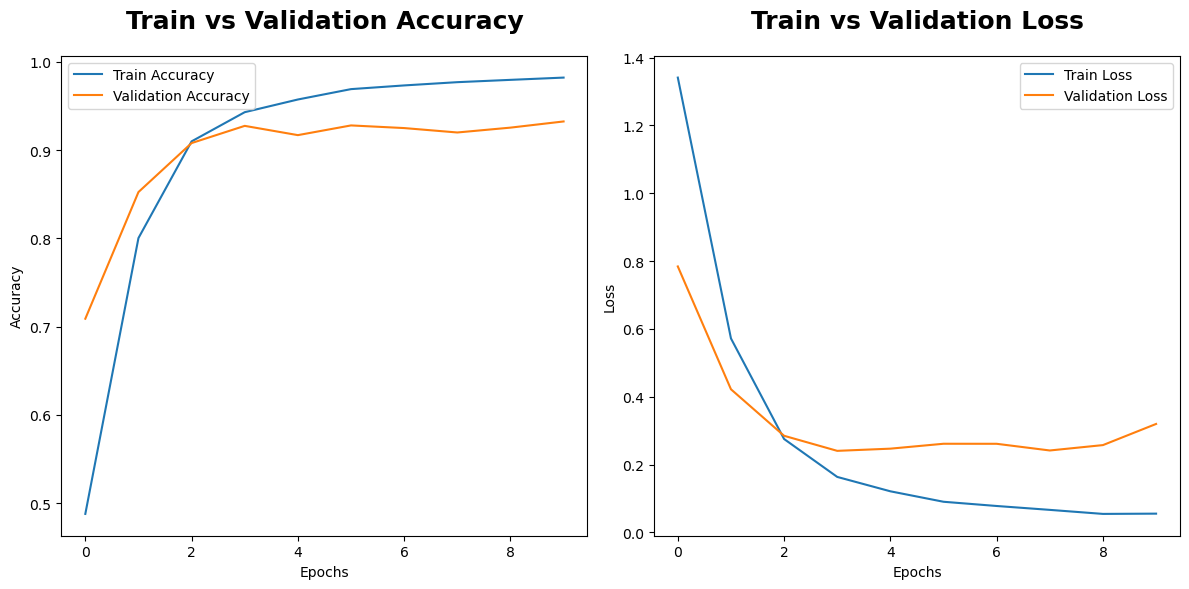

In [358]:
# Plotting training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [367]:
from tensorflow.keras.layers import Bidirectional, LSTM, Attention, Dense, Dropout, Embedding, GlobalMaxPooling1D,GlobalAveragePooling1D, Input
import tensorflow as tf
from tensorflow.keras.models import Model
from datasets import load_dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Load the 'dair-ai/emotion' dataset
dataset = load_dataset("dair-ai/emotion")

# Access the train, validation, and test splits
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

# Prepare the texts and labels
train_texts = train_data['text']
train_labels = train_data['label']
val_texts = val_data['text']
val_labels = val_data['label']
test_texts = test_data['text']
test_labels = test_data['label']

# Tokenize the text data
max_words = 10000  # You can set this according to your data
max_len = 100  # Set a max length for the input sequences

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences to make them of equal length
X_train = pad_sequences(train_sequences, maxlen=max_len)
X_val = pad_sequences(val_sequences, maxlen=max_len)
X_test = pad_sequences(test_sequences, maxlen=max_len)

# Convert labels to categorical if it's multi-class
y_train = to_categorical(train_labels, num_classes=6)  # Assuming 6 emotion classes, adjust as needed
y_val = to_categorical(val_labels, num_classes=6)
y_test = to_categorical(test_labels, num_classes=6)

# Define the model with an Input layer
input_layer = Input(shape=(max_len,))

# Embedding layer (no pre-trained embeddings)
embedding_layer = Embedding(input_dim=max_words, output_dim=100, input_length=max_len)(input_layer)  # 100D embeddings

# Bidirectional LSTM layer with Attention
lstm_out = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
# Attention mechanism
attention = Attention()([lstm_out, lstm_out])  # Shape: (None, 100, 256)

# Use global pooling (choose one method)
# Global Average Pooling
context = GlobalAveragePooling1D()(attention)  # Resulting shape: (None, 256)

# OR Global Max Pooling
# context = GlobalMaxPooling1D()(attention)  # Resulting shape: (None, 256)

# Fully connected layers
dense_layer = Dense(64, activation='relu')(context)  # Accepts 2D input (None, 256)
dropout_layer = Dropout(0.5)(dense_layer)  # Dropout for regularization
output_layer = Dense(6, activation='softmax')(dropout_layer)  # Final output layer

# Compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Evaluate the model on the test set
val_loss, val_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {val_acc * 100:.2f}%")


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_16        │ (None, 100, 100)  │  1,000,000 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_12    │ (None, 100, 256)  │    234,496 │ embedding_16[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_8         │ (None, 100, 256)  │          0 │ bidirectional_12… │
│ (Attention)         │                   │            │ bidirectional_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ attention_8[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │     16,448 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 6)         │        390 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,251,334 (4.77 MB)

 Trainable params: 1,251,334 (4.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 66s 125ms/step - accuracy: 0.3248 - loss: 1.6165 - val_accuracy: 0.3520 - val_loss: 1.5800
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 149ms/step - accuracy: 0.3237 - loss: 1.5350 - val_accuracy: 0.3090 - val_loss: 1.4296
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 160ms/step - accuracy: 0.3779 - loss: 1.4143 - val_accuracy: 0.4595 - val_loss: 1.1350
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 77s 153ms/step - accuracy: 0.4535 - loss: 1.0669 - val_accuracy: 0.7245 - val_loss: 0.7806
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 159ms/step - accuracy: 0.8132 - loss: 0.5498 - val_accuracy: 0.9145 - val_loss: 0.2763
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 159ms/step - accuracy: 0.9496 - loss: 0.1597 - val_accuracy: 0.9195 - val_loss: 0.2354
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 161ms/step - accuracy: 0.9632 - loss: 0.1106 - val_accuracy: 0.9305 - val_loss: 0.2120
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 77s 154ms/step - accuracy: 0.9712 - loss: 0

# Old code


lematizacija : https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
stop word: https://gist.github.com/sebleier/
To low words..


In [163]:
# Make decision tree classifier
dt_model_DTC = DecisionTreeClassifier(random_state=42)
dt_model_DTC.fit(X_train, y_train)
y_pred = dt_model_DTC.predict(X_val)


ValueError: could not convert string to float: 'i feel confused too'

In [209]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
print("Decision Tree Validation Accuracy:", accuracy_score(y_test, dt_predictions))
print(  (y_test, dt_predictions))
print(classification_report(y_test, dt_predictions))
dt_model.feature_importances_
# features = pd.DataFrame(dt_model.feature_importances_, index=vectorizer.get_feature_names_out(), columns=['Importance'])

# features.head(50)


feature_importances = pd.DataFrame({
    'Feature': vectorizer.get_feature_names_out(),
    'Importance': dt_model.feature_importances_
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
feature_importances_50 = feature_importances.head(50)

plt.figure(figsize=(20, 5))
plt.bar(feature_importances_50['Feature'], feature_importances_50['Importance'])
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Top 100 Feature Importances', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

top_100_features = feature_importances.head(400)

plt.figure(figsize=(20, 5))
plt.bar(top_100_features['Feature'], top_100_features['Importance'])
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Top 100 Feature Importances', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

# 0 sad    1443
# 1 joy    1703 ---------> love = 12, fear = 12
# 2 love     401 ----------> joy = 20, 
# 3 anger     671
# 4 fear     584
# 5 surprise     198 ----------> fear = 9
#

Decision Tree Validation Accuracy: 0.2735
(array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]]), array([[0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]]))
              precision    recall  f1-score   support

           0       0.35      0.35      0.35       581
           1       0.37      0.34      0.35       695
           2       0.08      0.09      0.09       159
           3       0.17      0.17      0.17       275
           4       0.17      0.21      0.19       224
           5       0.04      0.05      0.04        66

   micro avg       0.27      0.27      0.27      2000
   macro avg       0.20      0.20      0.20      2000
weighted avg       0.28      0.27      0.28  

c:\Users\Vid\miniconda3\envs\ls_a01\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: All arrays must be of the same length

In [204]:
# Get the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Identify the index of the feature corresponding to the word "feel"
if 'feel' in feature_names:
    feel_index = list(feature_names).index('feel')

    # Remove the "feel" column from X_train and X_test
    X_train = X_train[:, [i for i in range(X_train.shape[1]) if i != feel_index]]
    X_test = X_test[:, [i for i in range(X_test.shape[1]) if i != feel_index]]

    # Remove the "feel" from feature names
    feature_names = np.delete(feature_names, feel_index)

# Fit the Decision Tree model again
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

# Evaluate the model
print("Decision Tree Validation Accuracy:", accuracy_score(y_test, dt_predictions))
#print(confusion_matrix(y_test, dt_predictions))
print(classification_report(y_test, dt_predictions))

# Feature importance visualization
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_model.feature_importances_
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot top 50 features
feature_importances_50 = feature_importances.head(50)
plt.figure(figsize=(20, 5))
plt.bar(feature_importances_50['Feature'], feature_importances_50['Importance'])
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Top 50 Feature Importances', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()


Decision Tree Validation Accuracy: 0.2735
              precision    recall  f1-score   support

           0       0.35      0.35      0.35       581
           1       0.37      0.34      0.35       695
           2       0.08      0.09      0.09       159
           3       0.17      0.17      0.17       275
           4       0.17      0.21      0.19       224
           5       0.04      0.05      0.04        66

   micro avg       0.27      0.27      0.27      2000
   macro avg       0.20      0.20      0.20      2000
weighted avg       0.28      0.27      0.28      2000
 samples avg       0.27      0.27      0.27      2000



c:\Users\Vid\miniconda3\envs\ls_a01\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: All arrays must be of the same length

In [15]:
param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt_model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)
best_dt_model = grid_search.best_estimator_

val_predictions = best_dt_model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)

test_predictions = best_dt_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)

print("Best Parameters:", grid_search.best_params_)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, test_predictions))
print("\nClassification Report (Test Data):\n", classification_report(y_test, test_predictions))


Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: 

In [8]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
print("Random Forest Validation Accuracy:", accuracy_score(y_test, rf_predictions))
print(confusion_matrix(y_test, rf_predictions))

Random Forest Validation Accuracy: 0.82
[[232  39   2   5   8   3]
 [ 12 304  11   4   5   4]
 [  3  20  56   0   1   0]
 [  5  12   0 113   4   0]
 [  5  21   1   1  79  10]
 [  0   3   0   0   1  36]]


In [26]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_val)
print("Gradient Boosting Validation Accuracy:", accuracy_score(y_val, gb_predictions))

Gradient Boosting Validation Accuracy: 0.804


In [ ]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)

nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_confusion_matrix = confusion_matrix(y_test, nb_predictions)
nb_classification_report = classification_report(y_test, nb_predictions)

print("Naive Bayes Validation Accuracy:", nb_accuracy)
print("Confusion Matrix:\n", nb_confusion_matrix)
print("Classification Report:\n", nb_classification_report)

# Naive Bayes assumes that features are conditionally independent given the class label. 
# This assumption rarely holds true in real-world NLP tasks, as words in a sentence are often dependent on each other.
# For example, in the text "I am so happy and excited!", the words "happy" and "excited" are semantically related, 
# which Naive Bayes cannot model effectively.



Naive Bayes Validation Accuracy: 0.597
Confusion Matrix:
 [[236  52   0   1   0   0]
 [ 13 327   0   0   0   0]
 [ 19  61   0   0   0   0]
 [ 45  67   0  22   0   0]
 [ 36  68   0   1  12   0]
 [  6  34   0   0   0   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.82      0.73       289
           1       0.54      0.96      0.69       340
           2       0.00      0.00      0.00        80
           3       0.92      0.16      0.28       134
           4       1.00      0.10      0.19       117
           5       0.00      0.00      0.00        40

    accuracy                           0.60      1000
   macro avg       0.52      0.34      0.31      1000
weighted avg       0.61      0.60      0.51      1000



c:\Users\marko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\marko\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [36]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)


svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_confusion_matrix = confusion_matrix(y_test, svm_predictions)
svm_classification_report = classification_report(y_test, svm_predictions)

print("SVM Validation Accuracy:", svm_accuracy)
print("Confusion Matrix:\n", svm_confusion_matrix)
print("Classification Report:\n", svm_classification_report)

SVM Validation Accuracy: 0.827
Confusion Matrix:
 [[251  21   4   5   7   1]
 [ 12 310   8   5   4   1]
 [  4  24  50   1   1   0]
 [ 16   9   0 106   3   0]
 [ 17  10   1   1  83   5]
 [  1   6   0   0   6  27]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       289
           1       0.82      0.91      0.86       340
           2       0.79      0.62      0.70        80
           3       0.90      0.79      0.84       134
           4       0.80      0.71      0.75       117
           5       0.79      0.68      0.73        40

    accuracy                           0.83      1000
   macro avg       0.82      0.76      0.79      1000
weighted avg       0.83      0.83      0.82      1000



In [39]:
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X_train, y_train)
logistic_predictions = logistic_model.predict(X_test)

logistic_accuracy = accuracy_score(y_test, logistic_predictions)
logistic_confusion_matrix = confusion_matrix(y_test, logistic_predictions)
logistic_classification_report = classification_report(y_test, logistic_predictions)

print("Logistic Regression Validation Accuracy:", logistic_accuracy)
print("Confusion Matrix:\n", logistic_confusion_matrix)
print("Classification Report:\n", logistic_classification_report)

Logistic Regression Validation Accuracy: 0.748
Confusion Matrix:
 [[251  29   2   2   5   0]
 [ 12 326   1   1   0   0]
 [ 14  46  19   0   1   0]
 [ 21  26   0  85   2   0]
 [ 23  29   1   1  60   3]
 [  4  27   0   0   2   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.87      0.82       289
           1       0.67      0.96      0.79       340
           2       0.83      0.24      0.37        80
           3       0.96      0.63      0.76       134
           4       0.86      0.51      0.64       117
           5       0.70      0.17      0.28        40

    accuracy                           0.75      1000
   macro avg       0.80      0.56      0.61      1000
weighted avg       0.78      0.75      0.72      1000



# Task 3 - Advanced Machine learning 